In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import time

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

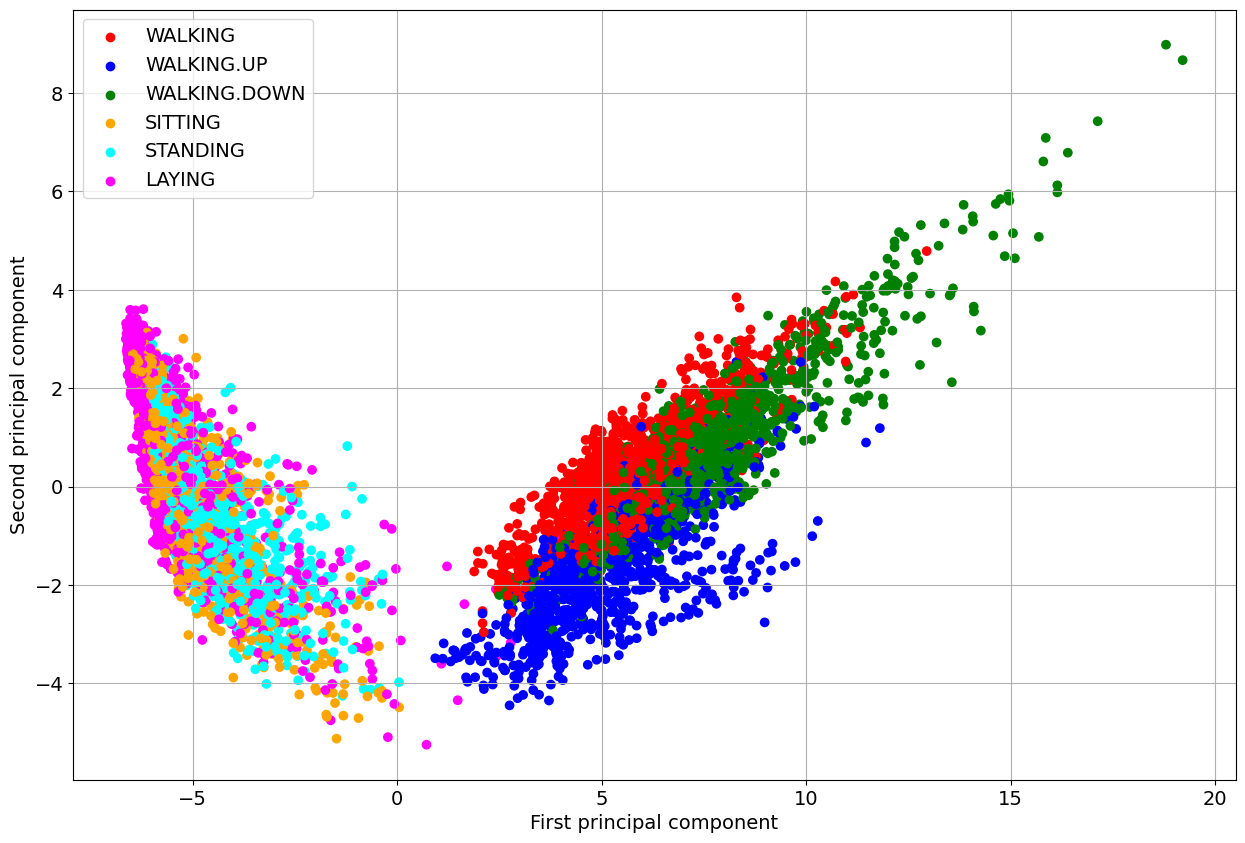

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [6]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torchsummary

D:\AnacondaGO\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [11]:
from torch.utils.data import TensorDataset, DataLoader

In [12]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [13]:
train_iter = iter(train_dataloader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [15]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch.squeeze(1))
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch.squeeze(1))

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.squeeze(1).cpu() == y_pred.cpu()).numpy()))

        
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

    return train_loss, val_loss, val_accuracy

In [16]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [17]:
input_shape = 128*9
num_classes = 6

model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, input_shape//4),
            nn.ReLU(),
            nn.Linear(input_shape//4, num_classes),
            nn.LogSoftmax(dim=1)
        )

model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

In [18]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_dataloader, test_dataloader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 4.406s
Epoch 2 of 30 took 4.476s
Epoch 3 of 30 took 4.402s
Epoch 4 of 30 took 4.292s
Epoch 5 of 30 took 4.398s
Epoch 6 of 30 took 4.339s
Epoch 7 of 30 took 4.374s
Epoch 8 of 30 took 4.677s
Epoch 9 of 30 took 5.002s
Epoch 10 of 30 took 4.841s
Epoch 11 of 30 took 4.763s
Epoch 12 of 30 took 4.744s
Epoch 13 of 30 took 4.684s
Epoch 14 of 30 took 4.571s
Epoch 15 of 30 took 4.622s
Epoch 16 of 30 took 4.713s
Epoch 17 of 30 took 4.584s
Epoch 18 of 30 took 4.602s
Epoch 19 of 30 took 4.604s
Epoch 20 of 30 took 4.701s
Epoch 21 of 30 took 5.815s
Epoch 22 of 30 took 6.054s
Epoch 23 of 30 took 5.858s
Epoch 24 of 30 took 6.541s
Epoch 25 of 30 took 6.229s
Epoch 26 of 30 took 5.446s
Epoch 27 of 30 took 5.137s
Epoch 28 of 30 took 5.001s
Epoch 29 of 30 took 5.962s
Epoch 30 of 30 took 4.937s


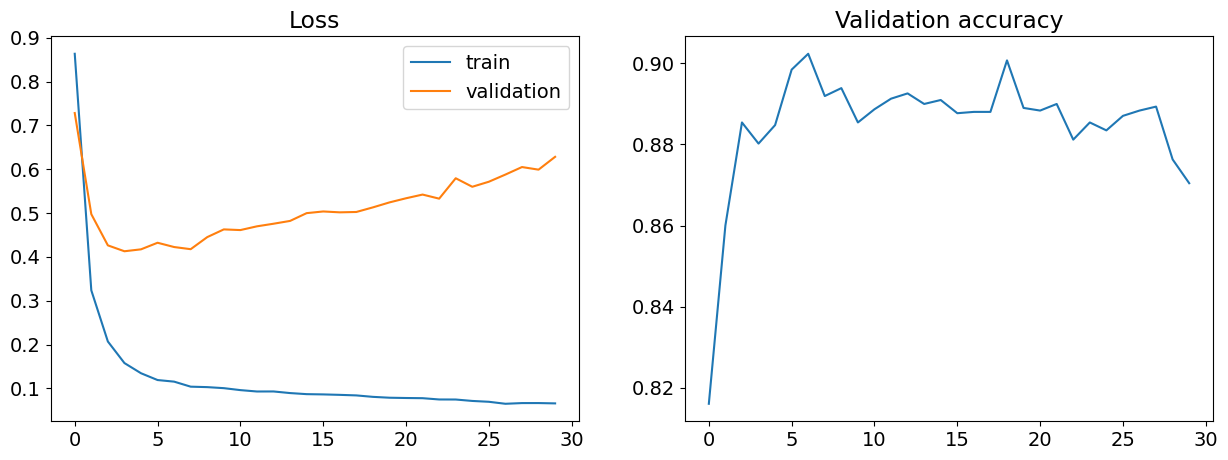

In [19]:
plot_train_process(train_loss, val_loss, val_accuracy)


In [20]:
torchsummary.summary(model.to(device), (128*9,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 1152]               0
            Linear-2                  [-1, 288]         332,064
              ReLU-3                  [-1, 288]               0
            Linear-4                    [-1, 6]           1,734
        LogSoftmax-5                    [-1, 6]               0
Total params: 333,798
Trainable params: 333,798
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.27
Estimated Total Size (MB): 1.29
----------------------------------------------------------------


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)



Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)


10000

In [6]:

for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)


In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [10]:
torchsummary.summary(model.to(device), (28*28,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [13]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        #start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()

            X_batch.to(device)
            y_batch.to(device)

            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch.to(device)
                y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

    return train_loss, val_loss, val_accuracy

In [14]:
n_epochs = 25

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not NoneType

In [20]:
import string
import os
import numpy as np


In [21]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [22]:
str = "";
for i in range(len(text)):
    str = str + text[i]

text = str.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!') 

OK!


In [5]:
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text] 

In [17]:
tmp = []
for i in range(0, len(text)):
    tmp.append(text[i].lower())

text = tmp

In [23]:
import re
parts = re.split('\n\n\s*[a-z]*\n\n', text) 

In [24]:
text 

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee.\n\n  ii\n\n  when forty winters shall besiege thy brow,\n  and dig deep trenches in thy beauty's field,\n  thy youth's proud livery so gazed on now,\n  will be a tatter'd weed of small worth held:\n  then being asked, where all thy beauty lies,\n  where all the treasure of thy lusty days;\n  to say, within thine own deep sunken eyes,\n  were

In [25]:
tokens = sorted(set(text))
print(tokens)

print(len(tokens))

['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
38


In [26]:
token_to_idx = {}
idx_to_token = {}

for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i;
    idx_to_token[i] = tokens[i];
    
num_tokens = len(tokens)

In [27]:
def to_matrix(parts, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    max_len = max_len or max(map(len, parts))
    parts_ix = np.zeros([len(parts), max_len], dtype) + pad

    for i in range(len(parts)):
        line_ix = [token_to_idx[c] for c in parts[i]]
        parts_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        parts_ix = np.transpose(names_ix)

    return parts_ix

In [28]:

batch_ix = to_matrix(parts[:5])
print(batch_ix)

[[ 1  1 17 ...  1  1  1]
 [ 1  1 34 ... 23 15  8]
 [ 1  1 23 ...  1  1  1]
 [ 1  1 32 ...  1  1  1]
 [ 1  1 31 ...  1  1  1]]


In [29]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

D:\AnacondaGO\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
      
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)



In [31]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [32]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [33]:
from IPython.display import clear_output
from random import sample
import time
 

In [34]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []


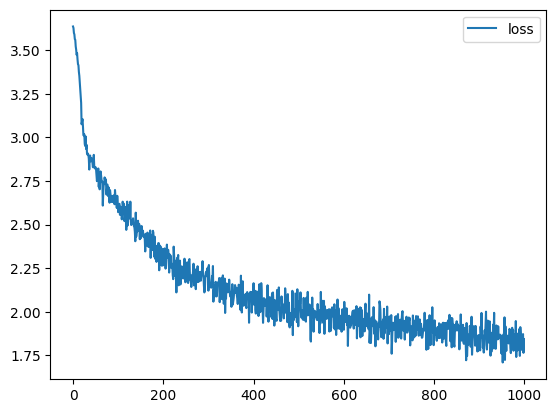

In [35]:
for i in range(1000):
    batch_ix = to_matrix(sample(parts, 2))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
    

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."


In [68]:
MAX_LENGTH = 500
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    print(x_sequence[:, :, 0][0])
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, :, i].shape, hid_state.shape)
        print(x_sequence.shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, :, i][0], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
nn.CrossEntropyLoss()

In [69]:
for _ in range(4):
    print(generate_sample(char_rnn, "when", temperature=0.8))
    print('\n\n')

tensor([34])
torch.Size([1, 1]) torch.Size([1, 64])
torch.Size([1, 1, 4]) torch.Size([1, 64])
torch.Size([1, 1]) torch.Size([1, 38])
torch.Size([1, 1, 4]) torch.Size([1, 38])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x54 and 80x64)